# Retrieval-Augmented Shopping Assistant - EDA

This notebook explores the ABO dataset for initial insights.

In [14]:
import pandas as pd

In [ ]:
# Load ABO image dataset
df_img = pd.read_csv("/kaggle/input/amazon-berkeley-objects/images/metadata/images.csv")  # or csv if applicable

In [ ]:
# 1. Check structure
print(df_img.shape)
print(df_img.columns)
print(df_img.dtypes)

# 2. Check missing values
print(df_img.notnull().sum())

# 3. Sample record
df_img.sample(5)

# 4. (If possible) display an image
from PIL import Image
import matplotlib.pyplot as plt

img_loc = str(df_img.loc[df_img['path']== '8c/8ccb5859.jpg']['path']).split()[1]
img_path = '/kaggle/input/amazon-berkeley-objects/images/small/' + img_loc  # based on image_id field
img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
# Load ABO metadata dataset

import os, glob
full_metadata = pd.DataFrame()
for json_file in glob.glob("/kaggle/input/listing/listings/metadata/*.json"):
    print('Loading file: ' + json_file + '\n')
    df_metadata = pd.read_json(json_file, lines = True)
    full_metadata = pd.concat([full_metadata, df_metadata])

In [ ]:
# 1. Check structure
print(full_metadata.shape)
print(full_metadata.columns)
print(full_metadata.dtypes)

In [5]:
# 2. Check missing values
print(full_metadata.notnull().sum())

brand                  147643
bullet_point           131570
color                  116180
item_id                147702
item_name              147702
item_weight            106194
material                53585
model_name              81579
model_number           124091
product_type           147702
main_image_id          147127
other_image_id         137976
item_keywords          126776
country                147702
marketplace            147702
domain_name            147702
node                   140749
style                   43188
item_dimensions         43338
model_year               7765
color_code              18243
spin_id                  8222
3dmodel_id               7960
fabric_type              8193
item_shape               5066
pattern                  4590
product_description      4240
finish_type              1536
dtype: int64


From above, "finish_type" column has the lowest number of values present i.e. 1536 out of 147702 product entries.

In [18]:
#Find duplicate item_id rows

duplicate_counts = full_metadata['item_id'].value_counts()
duplicate_counts = duplicate_counts[duplicate_counts > 1]
print(duplicate_counts)

item_id
B01BC2TBZ4    5
B00MEAYVH2    5
B00Q4TK5KG    5
B00Q6EY5UU    5
B07F87HC4V    4
             ..
B07R8FR8S4    2
B07Z58WTMK    2
B082MV768H    2
B06X9GMSD5    2
B07RPND47Z    2
Name: count, Length: 1932, dtype: int64


In [19]:
full_metadata.loc[full_metadata['item_id'] == 'B01BC2TBZ4']

,brand,bullet_point,color,item_id,item_name,item_weight,material,model_name,model_number,product_type,main_image_id,other_image_id,item_keywords,country,marketplace,domain_name,node,style,item_dimensions,model_year,color_code,spin_id,3dmodel_id,fabric_type,item_shape,pattern,product_description,finish_type
3100,"[{'language_tag': 'es_ES', 'value': 'AmazonBasics'}, {'language_tag': 'pt_PT', 'value': 'AmazonBasics'}]","[{'language_tag': 'es_ES', 'value': 'Juego de X o X fundas para proteger tu almohada.'}, {'language_tag': 'es_ES', 'value': 'Fabricadas de algodón 100% (85 g/m²) para una capa de confort extra.'}, {'language_tag': 'es_ES', 'value': 'Cremallera oculta para mantener la almohada en su sitio durante toda la noche.'}, {'language_tag': 'es_ES', 'value': 'Lavable en lavadora con colores similares (hasta 40 °C).'}, {'language_tag': 'es_ES', 'value': 'Cada una mide X x X cm.'}, {'language_tag': 'pt_PT', 'value': 'X ou X capas para proteger o seu travesseiro.'}, {'language_tag': 'pt_PT', 'value': 'Feito de algodão 100% (85g/m²) para uma camada extra de conforto.'}, {'language_tag': 'pt_PT', 'value': 'Zíper oculto para manter a almofada no lugar toda a noite.'}, {'language_tag': 'pt_PT', 'value': 'Lavável na máquina com cores semelhantes (até 40 °C).'}, {'language_tag': 'pt_PT', 'value': 'Cada uma mede x x x cm.'}]",NaN,B01BC2TBZ4,"[{'language_tag': 'es_ES', 'value': 'AmazonBasics 100% Cotton Soft Pillow Case with Zip'}, {'language_tag': 'pt_PT', 'value': 'AmazonBasics 100% Cotton Soft Pillow Case with Zip'}]",NaN,NaN,NaN,NaN,[{'value': 'HOME_BED_AND_BATH'}],71hiSKP7S6L,[71vbYUabUlL],"[{'language_tag': 'es_ES', 'value': 'EFN_UKES_mllutter'}, {'language_tag': 'pt_PT', 'value': 'EFN_UKES_mllutter'}]",ES,Amazon,amazon.es,"[{'node_id': 3250027031, 'node_name': '/Categorías/Textiles del hogar/Ropa de cama y almohadas/Sábanas y fundas de almohada/Fundas para almohada'}]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5348,"[{'language_tag': 'it_IT', 'value': 'AmazonBasics'}]","[{'language_tag': 'it_IT', 'value': 'Set di X o X federe copricuscino.'}, {'language_tag': 'it_IT', 'value': 'Realizzate in 100% cotone (85 g/mq) per aggiungere uno strato extra di morbido comfort.'}, {'language_tag': 'it_IT', 'value': 'Cerniera nascosta per tenere il cuscino in posizione durante la notte.'}, {'language_tag': 'it_IT', 'value': 'Lavabili in lavatrice con colori simili (fino a 40°C).'}, {'language_tag': 'it_IT', 'value': 'Dimensioni: X x X cm ciascuna.'}]",NaN,B01BC2TBZ4,"[{'language_tag': 'it_IT', 'value': 'AmazonBasics 100% Cotton Soft Pillow Case with Zip'}]",NaN,NaN,NaN,NaN,[{'value': 'HOME_BED_AND_BATH'}],413jqtAkNSL,"[61zQgNq1DtL, 616p93l+d5L, 61ZKCJ0ilkL, 61i6maIErCL, 71vbYUabUlL, 71wsn+knMWL]","[{'language_tag': 'it_IT', 'value': 'efn_ukit_mllutter'}]",IT,Amazon,amazon.it,"[{'node_id': 731786031, 'node_name': '/Categorie/Tessili per la casa/Biancheria da letto/Lenzuola e federe/Federe'}]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
537,"[{'language_tag': 'fr_FR', 'value': 'AmazonBasics'}]","[{'language_tag': 'fr_FR', 'value': 'Lot de X taies d'oreiller'}, {'language_tag': 'fr_FR', 'value': 'Fabriquées entièrement en coton (85 g/m²) pour une douceur et un confort optimaux'}, {'language_tag': 'fr_FR', 'value': 'Fermeture Éclair intégrée permettant de maintenir l'oreiller en place pendant la nuit'}, {'language_tag': 'fr_FR', 'value': 'Lavable en machine avec des couleurs similaires (40 °C maximum)'}, {'language_tag': 'fr_FR', 'value': 'Dimensions : X x X cm chacune'}]",NaN,B01BC2TBZ4,"[{'language_tag': 'fr_FR', 'value': 'AmazonBasics Taies d'oreiller 100 % coton doux avec fermeture'}]",NaN,NaN,NaN,NaN,[{'value': 'HOME_BED_AND_BATH'}],61i6maIErCL,[71vbYUabUlL],"[{'language_tag': 'fr_FR', 'value': 'EFN_UKFR_mllutter'}]",FR,Amazon,amazon.fr,"[{'node_id': 3213184031, 'node_name': '/Catégories/Ameublement et décoration/Literie et linge de maison/Linge de lit et oreillers/Draps et taies d'oreillers/Taies d'oreillers'}]",NaN,NaN,NaN,NaN,NaN,NaN,NaN

There are duplicate item_ids, because of multiple language support. We will remove duplicates after creating 
a scoped dataframe for supported language.

In [27]:
# 3. Sample record
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
#full_metadata.sample(5)

From above, it is clear that:
1. Only **item_name** column is present for all products.
2. We will use **item_name** to filter for in scope language - English.

In [20]:
# 4. Display an image using image id from the metadata

from PIL import Image
import matplotlib.pyplot as plt
print(full_metadata.loc[full_metadata['main_image_id'] == '413jqtAkNSL'])

                                                     brand  \
5348  [{'language_tag': 'it_IT', 'value': 'AmazonBasics'}]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    bullet_point  \
5348  [{'language_tag': 'it_IT', 'value': 'Set di X o X federe copricuscino.'}, {'language_tag': 'it_IT', 'value': 'Realizzate in 100% cotone (85 g/mq) per aggiungere uno strato extra di morbido comfort.'}, {'language_tag': 'it_IT', 'value': 'Cerniera nascosta per tenere il cuscino in posizione durante la notte.'}, {'language_tag': 'it_IT', 'value': 'Lavabili in lavatrice con colori simil

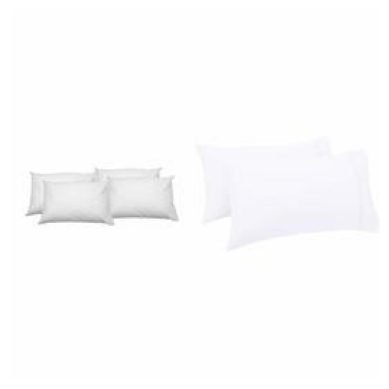

In [21]:
img_row = full_metadata.loc[full_metadata['main_image_id'] == '413jqtAkNSL']
img_id = img_row.iloc[0]['main_image_id']
img_location = str(df_img.loc[df_img['image_id'] == img_id]['path'])
img = Image.open('/kaggle/input/amazon-berkeley-objects/images/small/' + img_location.split()[1])
plt.imshow(img)
plt.axis('off')
plt.show()

In [22]:
# Analyse the number of languages supported. US-English in scope only.
count_US_lang_key = 0
count_prodDesc = 0
count_total=0
lang_set = set()
for val in full_metadata['item_name']:
    count_total += 1
    for key, value in val[0].items():
        if(key == 'language_tag'):
            lang_set.add(value)
print(lang_set)

{'ko_KR', 'es_MX', 'zh_TW', 'sv_SE', 'en_AU', 'fr_CA', 'en_CA', 'he_IL', 'es_US', 'kn_IN', 'tr_TR', 'hi_IN', 'zh_CN', 'en_GB', 'nl_NL', 'pt_BR', 'fr_FR', 'te_IN', 'ja_JP', 'en_IN', 'es_ES', 'en_US', 'ar_AE', 'en_SG', 'ml_IN', 'en_AE', 'cs_CZ', 'it_IT', 'pl_PL', 'de_DE'}


Amongst these, only English language will be used. i.e,
en_SG,
en_CA,
en_AU,
en_GB, 
en_AE, 
en_US,
en_IN

In [29]:
# Analyse the number of languages supported. US-English in scope only.
countTotalProdDesc = 0
countTotalEngDesc = 0
for val in full_metadata['item_name']:
    for key, value in val[0].items():
        if(key == 'language_tag'and value in ('en_SG', 'en_CA','en_AU','en_GB','en_AE','en_US','en_IN')):
            #list_items = list(val[0].items())
            #print(list_items[1])
            countTotalEngDesc += 1
        countTotalProdDesc += 1 

print('countTotalEngDesc: ', countTotalEngDesc)
print('countTotalProdDesc: ', countTotalProdDesc)
print('Percentage of data under scope:', countTotalEngDesc/countTotalProdDesc * 100)

countTotalEngDesc:  106474
countTotalProdDesc:  295528
Percentage of data under scope: 36.02839663246799


In [11]:
# Reduce the metadata to in scope languages only

# Step 1: Store indices of rows that match the language criteria
matching_indices = []

valid_languages = {'en_SG', 'en_CA','en_AU','en_GB','en_AE','en_US','en_IN'}

for idx, row in full_metadata.iterrows():
    item_name = row['item_name']
    if isinstance(item_name, list):
        if any(d.get('language_tag') in valid_languages for d in item_name if isinstance(d, dict)):
            matching_indices.append(idx)

# Step 2: Filter all at once using .iloc
inScopeMetadata = full_metadata.iloc[matching_indices].reset_index(drop=True)

In [12]:
#Find duplicate item_id rows

duplicate_counts = inScopeMetadata['item_id'].value_counts()
duplicate_counts = duplicate_counts[duplicate_counts > 1]
print(duplicate_counts)

item_id
B0746MMVXW    28
B07WC622LH    28
B07797D9MW    27
B073S3R169    26
B01928HSB4    26
              ..
B07GN662BP     7
B07RRWD8QB     7
B07RR3RFHT     7
B01719EX2S     7
B07HFTZ8YW     7
Name: count, Length: 9225, dtype: int64


In [13]:
inScopeMetadata.loc[inScopeMetadata['item_id'] == 'B07GN662BP']

,brand,bullet_point,color,item_id,item_name,item_weight,material,model_name,model_number,product_type,...,item_dimensions,model_year,color_code,spin_id,3dmodel_id,fabric_type,item_shape,pattern,product_description,finish_type
30949,"[{'language_tag': 'it_IT', 'value': 'UMI'}]","[{'language_tag': 'it_IT', 'value': 'Scegli il...","[{'language_tag': 'it_IT', 'value': 'Nero'}]",B07GN662BP,"[{'language_tag': 'it_IT', 'value': 'UMI. Esse...",NaN,NaN,NaN,[{'value': '.'}],[{'value': 'SPORTING_GOODS'}],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38683,"[{'language_tag': 'it_IT', 'value': 'UMI'}]","[{'language_tag': 'it_IT', 'value': 'Scegli il...","[{'language_tag': 'it_IT', 'value': 'Nero'}]",B07GN662BP,"[{'language_tag': 'it_IT', 'value': 'UMI. Esse...",NaN,NaN,NaN,[{'value': '.'}],[{'value': 'SPORTING_GOODS'}],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61738,"[{'language_tag': 'it_IT', 'value': 'UMI'}]","[{'language_tag': 'it_IT', 'value': 'Scegli il...","[{'language_tag': 'it_IT', 'value': 'Nero'}]",B07GN662BP,"[{'language_tag': 'it_IT', 'value': 'UMI. Esse...",NaN,NaN,NaN,[{'value': '.'}],[{'value': 'SPORTING_GOODS'}],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69417,"[{'language_tag': 'it_IT', 'value': 'UMI'}]","[{'language_tag': 'it_IT', 'value': 'Scegli il...","[{'language_tag': 'it_IT', 'value': 'Nero'}]",B07GN662BP,"[{'language_tag': 'it_IT', 'value': 'UMI. Esse...",NaN,NaN,NaN,[{'value': '.'}],[{'value': 'SPORTING_GOODS'}],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92449,"[{'language_tag': 'it_IT', 'value': 'UMI'}]","[{'language_tag': 'it_IT', 'value': 'Scegli il...","[{'language_tag': 'it_IT', 'value': 'Nero'}]",B07GN662BP,"[{'language_tag': 'it_IT', 'value': 'UMI. Esse...",NaN,NaN,NaN,[{'value': '.'}],[{'value': 'SPORTING_GOODS'}],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100096,"[{'language_tag': 'it_IT', 'value': 'UMI'}]","[{'language_tag': 'it_IT', 'value': 'Scegli il...","[{'language_tag': 'it_IT', 'value': 'Nero'}]",B07GN662BP,"[{'language_tag': 'it_IT', 'value': 'UMI. Esse...",NaN,NaN,NaN,[{'value': '.'}],[{'value': 'SPORTING_GOODS'}],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107772,"[{'language_tag': 'it_IT', 'value': 'UMI'}]","[{'language_tag': 'it_IT', 'value': 'Scegli il...","[{'language_tag': 'it_IT', 'value': 'Nero'}]",B07GN662BP,"[{'language_tag': 'it_IT', 'value': 'UMI. Esse...",NaN,NaN,NaN,[{'value': '.'}],[{'value': 'SPORTING_GOODS'}],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
def auto_flatten_json_columns(df, keys_to_try=['value', 'name', 'node_id', 'node_name']):
    """
    Detects and flattens columns containing lists of JSON objects,
    extracting specified keys.
    Adds new columns with a `_flat` suffix.
    """
    def extract_from_list(ld, keys):
        if isinstance(ld, list):
            for key in keys:
                values = [str(d.get(key)) for d in ld if isinstance(d, dict) and key in d]
                if values:  # found at least one valid value
                    return ", ".join(values)
        return None

    # Track flattened columns
    flattened = []

    for col in df.columns:
        sample = df[col].iloc[0]
        if isinstance(sample, list) and all(isinstance(i, dict) for i in sample):
            flat_col = f"{col}_flat"
            df[flat_col] = df[col].apply(lambda x: extract_from_list(x, keys_to_try))
            flattened.append(flat_col)

    return df, flattened

In [38]:
print(inScopeMetadata.shape)

NameError: name 'inScopeMetadata' is not defined

In [33]:
inScopeMetadata, flattened_cols = auto_flatten_json_columns(inScopeMetadata)
print("Flattened columns:", flattened_cols)


Flattened columns: ['brand_flat', 'bullet_point_flat', 'color_flat', 'item_name_flat', 'item_weight_flat', 'material_flat', 'model_name_flat', 'model_number_flat', 'product_type_flat', 'item_keywords_flat', 'node_flat']


In [ ]:
print(inScopeMetadata.columns)

In [44]:
print(full_metadata.shape)

(147702, 39)


In [40]:
full_metadata, flattened_cols = auto_flatten_json_columns(full_metadata)
print("Flattened columns:", flattened_cols)

Flattened columns: ['brand_flat', 'bullet_point_flat', 'color_flat', 'item_name_flat', 'item_weight_flat', 'material_flat', 'model_name_flat', 'model_number_flat', 'product_type_flat', 'item_keywords_flat', 'node_flat']


In [41]:
print(full_metadata.shape)

(147702, 39)


In [49]:
print(full_metadata.dtypes)

brand                  object
bullet_point           object
color                  object
item_id                object
item_name              object
item_weight            object
material               object
model_name             object
model_number           object
product_type           object
main_image_id          object
other_image_id         object
item_keywords          object
country                object
marketplace            object
domain_name            object
node                   object
style                  object
item_dimensions        object
model_year             object
color_code             object
spin_id                object
3dmodel_id             object
fabric_type            object
item_shape             object
pattern                object
product_description    object
finish_type            object
brand_flat             object
bullet_point_flat      object
color_flat             object
item_name_flat         object
item_weight_flat       object
material_f

In [43]:
# 2. Check missing values
print(full_metadata.notnull().sum())

brand                  147643
bullet_point           131570
color                  116180
item_id                147702
item_name              147702
item_weight            106194
material                53585
model_name              81579
model_number           124091
product_type           147702
main_image_id          147127
other_image_id         137976
item_keywords          126776
country                147702
marketplace            147702
domain_name            147702
node                   140749
style                   43188
item_dimensions         43338
model_year               7765
color_code              18243
spin_id                  8222
3dmodel_id               7960
fabric_type              8193
item_shape               5066
pattern                  4590
product_description      4240
finish_type              1536
brand_flat             147643
bullet_point_flat      131570
color_flat             116180
item_name_flat         147702
item_weight_flat       106194
material_f

In [50]:
full_metadata

,brand,bullet_point,color,item_id,item_name,item_weight,material,model_name,model_number,product_type,main_image_id,other_image_id,item_keywords,country,marketplace,domain_name,node,style,item_dimensions,model_year,color_code,spin_id,3dmodel_id,fabric_type,item_shape,pattern,product_description,finish_type,brand_flat,bullet_point_flat,color_flat,item_name_flat,item_weight_flat,material_flat,model_name_flat,model_number_flat,product_type_flat,item_keywords_flat,node_flat
0,"[{'language_tag': 'en_IN', 'value': 'Amazon Brand - Solimo'}]","[{'language_tag': 'en_IN', 'value': 'Snug fit for Samsung Galaxy A10s, with perfect cut-outs for volume buttons, audio and charging ports'}, {'language_tag': 'en_IN', 'value': 'Compatible with Samsung Galaxy A10s'}, {'language_tag': 'en_IN', 'value': 'Easy to put & take off with perfect cutouts for volume buttons, audio & charging ports.'}, {'language_tag': 'en_IN', 'value': 'Stylish design and appearance, express your unique personality.'}, {'language_tag': 'en_IN', 'value': 'Extreme precision design allows easy access to all buttons and ports while featuring raised bezel to life screen and camera off flat surface.'}, {'language_tag': 'en_IN', 'value': 'None'}]","[{'language_tag': 'en_IN', 'standardized_values': ['multi-colored'], 'value': 'Multicolor'}]",B0854774MY,"[{'language_tag': 'en_IN', 'value': 'Amazon Brand - Solimo Designer Chinnese Yin and Yang UV Printed Soft Back Case Mobile Cover for Samsung Galaxy A10s'}]","[{'normalized_value': {'unit': 'pounds', 'value': 0.11023113100000001}, 'unit': 'grams', 'value': 50}]","[{'language_tag': 'en_IN', 'value': 'Silicone'}]","[{'language_tag': 'en_IN', 'value': 'Samsung Galaxy A10s'}]",[{'value': 'UV10797-SL13059'}],[{'value': 'CELLULAR_PHONE_CASE'}],71owAzvPFuL,"[61+woWTqkwL, 61SE4RTPjdL]","[{'language_tag': 'en_IN', 'value': 'Back Cover'}, {'language_tag': 'en_IN', 'value': 'Designer Case'}, {'language_tag': 'en_IN', 'value': 'Designer Chinnese Yin and Yang Mobile Cover'}, {'language_tag': 'en_IN', 'value': 'Flexible Case'}, {'language_tag': 'en_IN', 'value': 'Printed Cover'}, {'language_tag': 'en_IN', 'value': 'Samsung Galaxy A10s Case'}, {'language_tag': 'en_IN', 'value': 'Silicone Case'}, {'language_tag': 'en_IN', 'value': 'Soft TPU'}, {'language_tag': 'en_IN', 'value': 'cases and covers'}, {'language_tag': 'en_IN', 'value': 'fashion case'}, {'language_tag': 'en_IN', 'value': 'mobile Cover'}]",IN,Amazon,amazon.in,"[{'node_id': 12538061031, 'node_name': '/Categories/Mobiles & Accessories/Mobile Accessories/Maintenance, Upkeep & Repairs/Replacement Parts/Back Covers'}, {'node_id': 12710103031, 'node_name': '/Categories/Mobiles & Accessories/Mobile Accessories/Cases & Covers/Back & Bumper Cases'}]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Amazon Brand - Solimo,"Snug fit for Samsung Galaxy A10s, with perfect cut-outs for volume buttons, audio and charging ports, Compatible with Samsung Galaxy A10s, Easy to put & take off with perfect cutouts for volume buttons, audio & charging ports., Stylish design and appearance, express your unique personality., Extreme precision design allows easy access to all buttons and ports while featuring raised bezel to life screen and camera off flat surface., None",Multicolor,Amazon Brand - Solimo Designer Chinnese Yin and Yang UV Printed Soft Back Case Mobile Cover for Samsung Galaxy A10s,50,Silicone,Samsung Galaxy A10s,UV10797-SL13059,CELLULAR_PHONE_CASE,"Back Cover, Designer Case, Designer Chinnese Yin and Yang Mobile Cover, Flexible Case, Printed Cover, Samsung Galaxy A10s Case, Silicone Case, Soft TPU, cases and covers, fashion case, mobile Cover","12538061031, 12710103031"
1,"[{'language_tag': 'en_US', 'value': 'Ravenna Home'}]",NaN,"[{'language_tag': 'en_US', 'value': 'Light Grey'}]",B07KRBPKT6,"[{'language_tag': 'en_US', 'value': 'Light Grey Swatch, Ravenna Home'}]","[{'normalized_value': {'unit': 'pounds', 'value': 0.1}, 'unit': 'pounds', 'value': 0.1}]",NaN,NaN,[{'value': '25030020-01'}],[{'value': 'B

In [45]:
# Construct the Embedding Input Text

embedding_cols = [
    'item_name_flat',
    'brand_flat',
    'product_type_flat',
    'material_flat',
    'bullet_point_flat',
    'color_flat',
    'item_keywords_flat'
]

inScopeMetadata['embedding_input'] = inScopeMetadata[embedding_cols].fillna('').agg(' '.join, axis=1)

In [36]:
inScopeMetadata.notnull().sum()

brand                  122699
bullet_point           109787
color                   96330
item_id                122734
item_name              122734
item_weight             88656
material                44673
model_name              68180
model_number           103348
product_type           122734
main_image_id          122240
other_image_id         114450
item_keywords          106357
country                122734
marketplace            122734
domain_name            122734
node                   116782
style                   36155
item_dimensions         36028
model_year               6107
color_code              15556
spin_id                  7354
3dmodel_id               7194
fabric_type              6880
item_shape               3927
pattern                  4002
product_description      3202
finish_type              1355
brand_flat             122699
bullet_point_flat      109787
color_flat              96330
item_name_flat         122734
item_weight_flat        88656
material_f

In [47]:
#Serialize to parquet/persistent storage

inScopeMetadata.to_parquet("inScopeMetadata_with_embeddings.parquet", index=False)


With above copy, we have:

inScopeMetadata_with_embeddings.parquet → all metadata + embedding inputs